# The Structure of Convolutional Neural Networks

### Dense Layers

A *densely-connected* layer is the easiest type of neural network layer to understand.  In a densely-connected layer, each unit receives inputs from all of the units in the previous layer, and the weighted connections into one unit are independent of the connections into the other units in the layer.  Here is a picture of a Dense layer with 5 units (the top row), each of which receives inputs from all 7 units in the previous layer (the bottom row):

<center><img src="images/dense_layer.png" width="30%"></center>

For each non-input unit in a network, you can think of the connections into that unit as representing the unit's "receptive field".  For example, the receptive fields of three different units are highlighted below in red.  As you can see, each receptive field covers the entire 7-unit "input space" of the previous layer.

<table width="90%">
<tr>
<td><img src="images/dense_layer_receptive_field0.png"></td>
<td><img src="images/dense_layer_receptive_field2.png"></td>
<td><img src="images/dense_layer_receptive_field3.png"></td>
</tr>
</table>

The weighted connections into different units are completely independent of each other.  During training, the backpropagation algorithm updates the weights of one unit's receptive field without regard to the other units' receptive fields.  This means that each unit in a layer is free to learn to respond to input patterns in its own unique way.  In other words, each connection in a densely-connected layer is an independent parameter of the network.

If we remember that each unit also maintains its own independent *bias* value, then we can easily calculate the total number of parameters in the network that are updated by backpropagation.  For example, for the densely-connected layer of 5 units shown above, with each unit receiving inputs from all 7 units in the previous layer, we have a total of

5 $\times$ 7 weights + 5 biases = 40 total trainable parameters

which we can verify by building a network containing a Dense output layer of 5 units that receives connections from a layer of 7 input units.

In [1]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense

In [2]:
network = Sequential(name='Example 1a')
network.add(InputLayer(7, name='input'))
network.add(Dense(5, name='output'))

In [3]:
network.summary()

Model: "Example 1a"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Dense)               (None, 5)                 40        
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


Notice that although we explicitly created an ``InputLayer`` of 7 units in the above network definition, this layer does not appear in the network summary, since input layers do not contain any trainable parameters themselves.  The input layer size is only needed to determine the number of parameters in the next layer (here, the ``Dense`` output layer).

An equivalent but more succinct way of specifying the input layer size is to use the ``input_shape`` keyword, instead of explicitly creating an ``InputLayer`` object, as in the example below:

In [4]:
network = Sequential(name='Example 1b')
network.add(Dense(5, name='output', input_shape=(7,)))

In [5]:
network.summary()

Model: "Example 1b"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Dense)               (None, 5)                 40        
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


### Self-Check 1

Suppose we have a densely-connected feedforward network with an input layer of 12 units, two hidden layers of 8 units and 5 units, and an output layer of 3 units.  How many total trainable parameters does this network have?  (Don't forget that each hidden and output unit has its own bias value, which counts as a trainable parameter.)

<center><img src="images/12_8_5_3_network.png" width="35%"></center>

In [6]:
network = Sequential(name='Self-Check 1')
network.add(Dense(8, name='hidden1', input_shape=(12,)))
network.add(Dense(5, name='hidden2'))
network.add(Dense(3, name='output'))
network.summary()

Model: "Self-Check 1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 8)                 104       
_________________________________________________________________
hidden2 (Dense)              (None, 5)                 45        
_________________________________________________________________
output (Dense)               (None, 3)                 18        
Total params: 167
Trainable params: 167
Non-trainable params: 0
_________________________________________________________________


In [7]:
hidden1_layer_params = (12 * 8) + 8
hidden2_layer_params = (8 * 5) + 5
output_layer_params = (5 * 3) + 3
total_params = hidden1_layer_params + hidden2_layer_params + output_layer_params
print(total_params)

167


### Topology Doesn't Matter

In a standard feedforward network with densely-connected layers, the precise order of the connections into a unit doesn't matter.  This is easy to see.  Consider the unlabeled output unit below, which has an input connection from every unit in the previous layer.  In this example, the input activation values are labeled **a**, **b**, **c**, etc., and the connection weights are the numbers shown in red (the connection weights are usually floating-point values rather than simple integers, but I'll use integers here for purposes of illustration). 

<center><img src="images/input-order1.png" width="30%"></center>

The output unit multiplies each connection weight by the corresponding input activation, adds everything up, including the unit's bias value (not shown), and possibly applies an activation function to the result.  The key thing to notice is that adding up the terms **a** $\!\cdot\!$ 1 + **b** $\!\cdot\!$ 2 + **c** $\!\cdot\!$ 3 + $\ldots$ + **g** $\!\cdot\!$ 7 can be done in any order.  Mathematically, you'll get the same result.  So we could re-order the input units and their connections however we like, and the output unit will still compute the same value.  For example:

<center><img src="images/input-order2.png" width="30%"></center>

Notice that in the new ordering of the input layer, which we might think of as its *topology*, the input units **a** and **f** are right next to each other, whereas originally they were far apart.  But this makes no difference from the output unit's point of view, for the simple reason that addition is commutative.

### Real-World Topology and Local Receptive Fields

What if the input layer represents real-world perceptual data, such as pixel values in an image, or sound intensities in an audio waveform, or sensor readings taken from a robot?  In this type of data, topology matters.  For example, two adjacent pixel values in an input image might correspond to physically adjacent points in space.  For audio data, adjacent input values might correspond to sound intensities measured at two consecutive moments in time.  A robot with a ring of sonar sensors might return a vector of values measuring the distances to objects at different angles from the robot, and adjacent values would correspond to readings taken in similar spatial directions.  In each of these cases, arbitrarily re-ordering the input values would cause valuable real-world topological information to be lost.  Previously-adjacent values (pixels, sonar readings, etc.) would now be far apart in the input pattern.  Of course, none of this matters from the output unit's point of view &mdash; assuming that the corresponding connection weights are also re-ordered in the same way &mdash; for the reasons outlined above.  The output unit would still compute exactly the same value.

<div class="alert alert-block alert-info">
<center>
Densely-connected layers are not sensitive to topological information that may be implicitly encoded in the ordering of values in the input data.
</center>
</div>

In contrast, **convolutional layers** are sensitive to the topological structure of the input data.  Instead of being densely-connected, each unit in a convolutional layer has a *limited* (or *local*) receptive field, that receives input from only *some* of the units in the previous layer, instead of from all of them.  For example, the units in the output layer shown below have receptive fields of size 3:  

<center><img src="images/conv_layer_1D.png" width="30%"></center>
    
Each unit receives input from a different region (of size 3) of the input layer:
    
<table width="90%">
<tr>
<td><img src="images/conv_layer_receptive_field0.png"></td>
<td><img src="images/conv_layer_receptive_field2.png"></td>
<td><img src="images/conv_layer_receptive_field3.png"></td>
</tr>
</table>



### Translation Invariance and Weight Sharing

You can think of a local receptive field as just a set of weighted connections into a unit, along with the unit's bias value.  A particular combination of weight and bias values makes the unit sensitive to certain types of patterns or **features** that occur in the region of the input associated with the receptive field.  (An example of such a feature might be an "edge" formed by adjacent regions of light and dark pixels in an image.)  If the weights and bias values of the three receptive fields shown in the picture above are independent of each other, then each of the output units will be sensitive to different features that occur in different regions of the input pattern.  For example, based on its own set of receptive-field weights (and bias), the leftmost output unit above might respond strongly to one type of feature that it detects in the leftmost three input units, while the middle output unit, using a different set of weights, might respond to a very different type of feature occurring in the middle three input units.

However, it usually doesn't matter *where* exactly in the input pattern a particular feature occurs.  We would like our network to learn to recognize features regardless of their precise location in the input.  For example, suppose our network is able to recognize the presence of a visual feature, say a short line segment oriented at some angle, at some particular location in an input image.  Now imagine that we shift the line segment over in the image by just a few pixels, keeping everything else the same.  We would still want the network to recognize the line segment, despite its shifted position (sometimes called a "translation").

To achieve this type of **translation invariance**, we need to have multiple units that will look for the *same* feature *at all possible locations* in the input.  Instead of each unit having its own independent set of weights, all of the units will **share** a single set of weight and bias values, but each unit will be connected to a different local region of the input.  For example, in the picture above, each of the five output units "looks at" a different region of the input, but they all share a common set of three weights and one bias value.

The convolutional layer architecture has several major advantages.  First, if the weight and bias parameters become sensitive to some type of feature during training, that feature can be detected no matter where it is located in the input, because there will be *some* output unit that is connected to the input region where the feature occurs.  Second, instead of requiring 20 separate trainable parameters, that is, (3 weights + 1 bias) $\times$ 5 output units, we only require 4 trainable parameters in all (3 weights + 1 bias), which are shared among all five output units.  The set of 3 shared weights is called a **kernel**, and the kernel weights together with the bias value is called a **filter**.

### A One-Dimensional Convolutional Layer

To make this more concrete, let's write some code that builds our example network below.

<center><img src="images/conv_layer_1D.png" width="30%"></center>

In [8]:
from tensorflow.keras.layers import Conv1D

In [9]:
network = Sequential(name='Example 2')
network.add(Conv1D(filters=1, 
                   kernel_size=3,
                   input_shape=(7,1),
                   name='output'))

We will use a 1-dimensional convolutional layer (``Conv1D``) for the output units, where each unit is connected to a receptive field of size 3 (``kernel_size``) in the input layer.  All of the units in the output layer share a single set of weight/bias parameters, so ``filters`` is 1.  Later on, we will see that a convolutional layer can keep track of more than one set of weight/bias parameters at a time, meaning that the units can learn to recognize several different features at once.  But for now we will keep things simple with just one filter.

The ``input_shape`` keyword specifies an input layer of seven units, but why is the shape ``(7,1)`` instead of ``(7,)`` like in our first example?  Because in general, layers in a convolutional network can consist of multiple **channels**.  You can think of each channel as a duplicate set of units.  In our example here, we only have one set of seven input units, so the number of channels is just 1.  But we must still specify the number of channels as part of the ``input_shape``.

In [10]:
network.summary()

Model: "Example 2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Conv1D)              (None, 5, 1)              4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


As the summary shows, the ``Conv1D`` layer has an output shape of ``(None, 5, 1)``, meaning five output units organized into a single output channel.  The ``None`` is there as a reminder that Keras layers always output a **batch** of patterns at a time, and we don't know the batch size in advance.  The 4 trainable parameters refer to the set of three weights plus the bias shared among all units in the layer.

Why does the output layer have 5 units?  Although this is what we want, we didn't explicitly specify the number of output units anywhere in the network definition, so how did Keras know to include 5 units?  That is a consequence of specifying ``kernel_size=3`` given an input layer of size 7.  Keras automatically deduced that in order to cover the entire input layer with receptive fields spaced one unit apart, a total of 5 output units are required.

### Multiple Input Channels

What would a multiple-channel input layer look like?  Suppose our input layer has two channels instead of just one.  We would then have two sets (or "banks", or "sublayers", or, well, "channels") of seven input units each:

<center><img src="images/conv_layer_1D_2channels.png" width="30%"></center>

How are the input units in the new channel connected to the output units?  Just like before: all of the input units within an output unit's receptive field, regardless of the channel, are connected to that output unit, and together the weights form the "kernel" that is shared among all output units.  For example, the picture below shows the receptive field of the leftmost and middle output unit.  The kernel now has 6 weights instead of 3, for a total of 7 trainable parameters (6 weights + 1 bias) shared among the output units:

<table width="65%">
<tr>
<td><img src="images/conv_layer_1D_2ch_receptive_field0.png"></td>
<td><img src="images/conv_layer_1D_2ch_receptive_field2.png"></td>
</tr>
</table>


In [11]:
network = Sequential(name='Example 3')
network.add(Conv1D(filters=1,
                   kernel_size=3,
                   input_shape=(7,2),  # changed (7,1) to (7,2)
                   name='output'))
network.summary()

Model: "Example 3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Conv1D)              (None, 5, 1)              7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


Likewise, if the input layer has 3 channels, there are 10 shared parameters (9 weights + 1 bias):

In [12]:
network = Sequential(name='Example 4')
network.add(Conv1D(filters=1,
                   kernel_size=3,
                   input_shape=(7,3),  # changed (7,2) to (7,3)
                   name='output'))
network.summary()

Model: "Example 4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Conv1D)              (None, 5, 1)              10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


### Size of the Input Layer

Suppose we now increase the size of the input layer, keeping the receptive field size (as specified by the ``kernel_size`` parameter in our network definition) and the number of input channels the same.  How would this change the total number of trainable parameters in the network?  For example, suppose we increase the input layer size from 7 to 1000 units, while still maintaining 3 input channels and receptive fields of size 3.  To completely cover the input space with receptive fields, many more output units will clearly be required, but the exact number is determined by the receptive field size.  In our case, with receptive fields of size 3, the output layer size will shrink by 2 units, for a total of 998 units instead of 1000.

<center><img src="images/layer_size_reduction.png" width="50%"></center>

But the number of trainable parameters doesn't change at all.  The layer still keeps track of just 10 parameters (9 weights + 1 bias), shared among all 998 output units.

In [13]:
network = Sequential(name='Example 5')
network.add(Conv1D(filters=1,
                   kernel_size=3,
                   input_shape=(1000,3),  # changed 7 to 1000
                   name='output'))
network.summary()

Model: "Example 5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Conv1D)              (None, 998, 1)            10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


### Multiple Filters

The number of channels in a layer is sometimes called its **depth**, so in the above network, the input layer has depth 3.  During training, the shared parameters will become sensitive to a particular type of feature occurring within the input data (at any or all input depths).  But in our example above, there is only a single set of shared parameters (specified by ``filters=1``), so the network can only learn to recognize, at most, one type of feature in the input.  In general, we want a convolutional layer to be able to potentially learn to recognize many different types of features in the input.  Therefore, most convolutional layers use multiple filters.  Remember that a "filter" is just a set of trainable parameters (weights + bias) that is shared among all units in a convolutional layer.

The above output layer has one filter, consisting of 10 parameters.  If we increase the number of filters to 2, there will be two independent sets of parameters:

In [14]:
network = Sequential(name='Example 6')
network.add(Conv1D(filters=2,  # increased filters from 1 to 2
                   kernel_size=3,
                   input_shape=(1000,3),
                   name='output'))
network.summary()

Model: "Example 6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Conv1D)              (None, 998, 2)            20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


Notice that the output layer shape now shows **2 output channels**.  Each output channel will hold the result of processing the input data using a different filter.  You can think of each channel as being a separate "parallel copy" of the output units, with an output activation pattern determined by that channel's own filter (weights + bias), independently of the other channels.  In a way, a convolutional layer with multiple filters has multiple distinct "personalities", each of which learns to respond in its own unique way to the input data.  Furthermore, the output channels of a layer can serve as the input channels to the next layer in sequence.

If we increase the number of filters to 4, the total number of trainable parameters doubles again, to 40, and we now have 4 output channels:

In [15]:
network = Sequential(name='Example 7')
network.add(Conv1D(filters=4,  # increased filters from 2 to 4
                   kernel_size=3,
                   input_shape=(1000,3),
                   name='output'))
network.summary()

Model: "Example 7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Conv1D)              (None, 998, 4)            40        
Total params: 40
Trainable params: 40
Non-trainable params: 0
_________________________________________________________________


As an illustration, the picture below shows the four channels of the output layer and the three channels of the input layer.  The filter parameters for channel 0 are highlighted in red, and are shared by all of the output units in channel 0 (here, only the leftmost unit's receptive field connections are shown).  The blue connections represent the filter parameters for channel 3, and are shared by all of the channel 3 output units (but only the connections into the rightmost unit are shown).  Likewise, the output units in channel 1 share their own set of 10 parameters (not shown), as do the units in channel 2, for a total of 40 trainable parameters.

<center><img src="images/conv1d_4filters.png" width="40%"></center>

### A Two-Dimensional Convolutional Layer

The examples above illustrate most of the key architectural concepts of convolutional layers.  However, in practice **2-dimensional** convolutional layers are much more common than 1-dimensional layers, because most convolutional neural networks are applied to the task of image processing.  To understand how 2-dimensional layers work, just increase the dimensionality of the input layer by one.  Instead of the input units being arranged in a linear sequence as in the examples above, they will be arranged in a "sheet" of units, where each unit might correspond to an individual pixel in an input image:

<center><img src="images/input_sheet_2d.png" width="30%"></center>

Different output units are connected to different local 2D receptive fields in the input image, which means that the output units themselves have a 2D topological arrangement that mirrors the arrangement of the input units.  Furthermore, all of the output units share a common set of weight and bias parameters.  For example, three different output units, each with 3 $\times$ 3 receptive fields, are shown below.  Each unit shares the same set of 9 connection weights (shown in red) and 1 bias value (not shown).

<table width="80%">
<tr>
<td><img src="images/conv2d_receptive_field1.png"></td>
<td><img src="images/conv2d_receptive_field2.png"></td>
<td><img src="images/conv2d_receptive_field3.png"></td>
</tr>
</table>

If the input layer has multiple channels (*i.e.* its depth is greater than 1), then each output unit connects to the input units *at all depths* of the receptive field.  Thus you can think of a unit in a 2D convolutional layer as receiving input from a 3-dimensional **volume** of units in the previous layer.  For example, color RGB images have three channels specifying the pixel intensities for red, green, and blue.  With three input channels, a receptive field of size 3 $\times$ 3 would constitute a volume of 27 pixel values, and the total number of trainable parameters would be: (3 $\times$ 3) weights $\times$ 3 channels + 1 bias = 28 parameters.  (For clarity, the receptive field connections from channels 0 and 1 are not shown in the picture below.)

<center><img src="images/input_sheet_2d_3channels.png" width="40%"></center>

The full set of output units and connections would look something like the following picture (again, for clarity the connections from the bottom two input channels are not shown.)  The size of the output layer shrinks by two units in each direction, due to the 3 $\times$ 3 receptive field size.  The 2-dimensional pattern of activation across the output units is called a **feature map**.

<center><img src="images/full_conv2d_3channels.png" width="40%"></center>

Here is the code to create the above layer:

In [16]:
from tensorflow.keras.layers import Conv2D

In [17]:
network = Sequential(name='Example 8')
network.add(Conv2D(filters=1,
                   kernel_size=(3,3),
                   input_shape=(5,5,3),
                   name='output'))
network.summary()

Model: "Example 8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Conv2D)              (None, 3, 3, 1)           28        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


Adding another filter to the layer is like adding another set of output units with their own independent set of 28 trainable parameters, which are shared among all of the new output units, bringing the total number of layer parameters to 56.  The new output units constitute a new **output channel**, as in the picture below.  The 2-dimensional pattern of activation on each output channel represents a **feature map** of size 3 $\times$ 3 computed from the 5 $\times$ 5 input image.  In the picture, only some of the connections from the input layer to the output layer are shown for clarity.  Keep in mind that the set of connections from output channel 0 also extends to the bottom two input channels as well.  Furthermore, the purple output units shown in the top output channel have their own separate set of connections to all three input channels as well.

<center><img src="images/full_conv2d_2filters.png" width="40%"></center>

In [18]:
network = Sequential(name='Example 9')
network.add(Conv2D(filters=2,  # changed filters from 1 to 2
                   kernel_size=(3,3),
                   input_shape=(5,5,3),
                   name='output'))
network.summary()

Model: "Example 9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Conv2D)              (None, 3, 3, 2)           56        
Total params: 56
Trainable params: 56
Non-trainable params: 0
_________________________________________________________________


As a final example, adding three more filters would add three more sets of 28 parameters, giving a total of [(3 $\times$ 3 $\times$ 3) + 1] $\times$ 5 = 140 trainable parameters.  Given an input image, the layer would produce 5 separate feature maps as output.

<center><img src="images/full_conv2d_5filters.png" width="40%"></center>

In [19]:
network = Sequential(name='Example 10')
network.add(Conv2D(filters=5,  # changed filters from 2 to 5
                   kernel_size=(3,3),
                   input_shape=(5,5,3),
                   name='output'))
network.summary()

Model: "Example 10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Conv2D)              (None, 3, 3, 5)           140       
Total params: 140
Trainable params: 140
Non-trainable params: 0
_________________________________________________________________


Since the number of trainable parameters is independent of the size of the input image, we could change the input size to be anything else, say 32 $\times$ 32 pixels, without affecting the number of parameters.  The output feature maps would then be of size 30 $\times$ 30.  In other words, the width and height of the input image doesn't matter.  All units in the layer share the same weights and bias for learning a feature, no matter where the feature occurs in the input image.

In [20]:
network = Sequential(name='Example 11')
network.add(Conv2D(filters=5,
                   kernel_size=(3,3),
                   input_shape=(32,32,3),  # changed input image size from 5x5 pixels to 32x32 pixels
                   name='output'))
network.summary()

Model: "Example 11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Conv2D)              (None, 30, 30, 5)         140       
Total params: 140
Trainable params: 140
Non-trainable params: 0
_________________________________________________________________


Instead of thinking of a convolutional layer as a collection of individual *units*, which all share a common set of weights and get their input from different regions of the input layer, it may be more helpful to think of a layer as a collection of **columns of units**.  Each unit in a column learns a different feature of the input data based on its own set of filter parameters, which are shared across all columns in the layer.  This idea is shown below, for the example of 32 $\times$ 32 pixel RGB input images and 5 output layer filters.  [[*image source*](https://cs231n.github.io/convolutional-networks)]

<center><img src="images/cs231n_convnet_layer.jpg" width="20%"></center>

### Padding

In the previous example, using a 3 &times; 3 kernel (receptive field) with an input image of size 32 &times; 32 pixels produced an output of size 30 &times; 30.  If we wish to keep the size of the output the same as the input, we can automatically pad the input image with extra 0s around the edges, so that the output will have the same height and width dimensions as the input.  To do this, just specify ``padding='same'``, as shown in the next example.

In [21]:
network = Sequential(name='Example 12')
network.add(Conv2D(filters=5,
                   kernel_size=(3,3),
                   input_shape=(32,32,3),
                   padding='same',  # keeps the output size the same as the input size
                   name='output'))
network.summary()

Model: "Example 12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Conv2D)              (None, 32, 32, 5)         140       
Total params: 140
Trainable params: 140
Non-trainable params: 0
_________________________________________________________________


### Self-Check 2

Suppose we create a 2D convolutional layer with 64 filters and 3 $\times$ 3 receptive fields, and feed it color RGB images of size 224 $\times$ 224 pixels.  How many trainable parameters will this layer have, and what will be the size of the feature maps created by the layer?

In [22]:
network = Sequential(name='Self-Check 2')
network.add(Conv2D(filters=64,
                   kernel_size=(3,3),
                   input_shape=(224,224,3),
                   name='output'))
network.summary()

Model: "Self-Check 2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Conv2D)              (None, 222, 222, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


In [23]:
64 * (3 * 3 * 3 + 1)

1792

What will the output shape be if we specify ``padding='same'``?

In [24]:
network = Sequential(name='Self-Check 2')
network.add(Conv2D(filters=64,
                   kernel_size=(3,3),
                   input_shape=(224,224,3),
                   padding='same',
                   name='output'))
network.summary()

Model: "Self-Check 2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
output (Conv2D)              (None, 224, 224, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


### Pooling Layers

Another important type of convolutional neural network layer is the *pooling* layer, of which there are several different varieties.  Both 1D and 2D versions are available, but the basic principle is the same for each.  The job of a pooling layer is to perform "downsampling", in which an image or other type of input pattern is reduced in size by extracting a subset of the available information from the pattern and throwing away the rest.  The result is, in some sense, a more abstract representation of the input that preserves only the most essential information.

One very common type of downsampling operation is called "max pooling", and is illustrated below.  The diagram shows a 2D image of pixels on the left (with individual pixel values labeled *a*, *b*, *c*, etc.), and a smaller image on the right created by finding the maximum of each non-overlapping 2 &times; 2 cluster of pixels in the original image.  A more concrete example is also shown.  The 2 &times; 2 pooling size results in the 6 &times; 6 input image being transformed into a smaller 3 &times; 3 output image, half the size of the original.

Other types of pooling operations are also possible, such as *average* pooling, in which each cluster of pixels is replaced by the average value of the pixels in the cluster instead of the maximum value.

#### 2 &times; 2 Max Pooling

<img src="images/maxpool_2x2.png" width="45%">

#### Example

<img src="images/maxpool_2x2_example.png" width="40%">

The code below adds a 2 &times; 2 ``MaxPooling2D`` layer to our earlier (un-padded) example network.

In [25]:
from tensorflow.keras.layers import MaxPooling2D

In [26]:
network = Sequential(name='Example 13')
network.add(Conv2D(filters=5,
                   kernel_size=(3,3),
                   input_shape=(32,32,3),
                   name='conv1'))
network.add(MaxPooling2D(pool_size=(2,2),  # added a 2x2 max pooling layer
                         name='pool1'))
network.summary()

Model: "Example 13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 30, 30, 5)         140       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 15, 15, 5)         0         
Total params: 140
Trainable params: 140
Non-trainable params: 0
_________________________________________________________________


Notice that the five output channels of the ``Conv2D`` layer, each of size 30 &times; 30, are transformed by the pooling layer into five new channels, each of size 15 &times; 15.  The number of trainable parameters of the network, however, does not change, because a pooling layer simply applies a single mathematical operation (*e.g.*, maximum, average, etc.) uniformly across its input.

#### 3 &times; 3 Max Pooling

Using a larger pooling size results in a smaller output image.  For example, with a 3 &times; 3 pooling size, an input image would be transformed into an output image one third of the original size, since each 3 &times; 3 cluster of pixel values gets transformed into a single value, as illustrated below.

<img src="images/maxpool_3x3.png" width="45%">

#### Example

<img src="images/maxpool_3x3_example.png" width="40%">

In [27]:
network = Sequential(name='Example 14')
network.add(Conv2D(filters=5,
                   kernel_size=(3,3),
                   input_shape=(32,32,3),
                   name='conv1'))
network.add(MaxPooling2D(pool_size=(3,3),  # changed (2,2) to (3,3)
                         name='pool1'))
network.summary()

Model: "Example 14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 30, 30, 5)         140       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 10, 10, 5)         0         
Total params: 140
Trainable params: 140
Non-trainable params: 0
_________________________________________________________________


The five 30 &times; 30 channels are now transformed by the ``MaxPooling2D`` layer into five new channels of size 10 &times; 10.

## A Pre-Trained Convolutional Network

To illustrate the ideas of convolutional neural networks more concretely, we will experiment with a complete, pre-trained network available in Keras, called a VGG16 network.  The VGG16 network was developed by the Visual Geometry Group at Oxford, and was trained on the large-scale ImageNet dataset, consisting of 1.4 million labeled images from 1,000 different categories.  Most of the images are of animals or other everyday objects, including many different breeds of cats and dogs.  The diagram below shows the architecture of the network along with the sizes and types of each layer.  For more detailed information, see the paper [K. Simonyan and A. Zisserman, Very deep convolutional networks for large-scale image recognition (2014)](https://arxiv.org/abs/1409.1556)

<img src="images/vgg16_architecture.jpg" width="75%">

In [28]:
from tensorflow.keras.applications import VGG16

In [29]:
vgg16 = VGG16(weights='imagenet')

Compare the summary of the network layers below to the above picture.

In [30]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

The network structure is organized into "blocks", each consisting of two or three convolutional layers followed by a 2 &times; 2 max-pooling layer that reduces the size of the resulting feature maps by 50%.  Each layer in the first block produces 64 different feature maps; each layer in the second block, 128 feature maps, and so on.  The schematic below shows the structure of each block, with convolutional layers in gray and max-pooling layers in red.  In the diagram, rectangle height reflects the relative *size* of the feature maps created at each layer, and rectangle width reflects the *number* of feature maps created.  As information flows through the network, the original input image is gradually transformed into a much smaller but more abstract representation of the image.  The output of the final max-pooling layer in block 5 is a set of 512 feature maps, each of size 7 &times; 7.  These feature maps then get "flattened" into a single vector of 4096 values, which is fed into the final densely-connected classification layers of the network.

<img src="images/vgg16_blocks.png" width="65%">

Let's feed a few input images to this pre-trained network and examine the resulting feature maps that get created on each intermediate layer.  First, we will download a set of images of cats and dogs, each of size 224 &times; 224 pixels.

In [31]:
!curl -O science.slc.edu/jmarshall/bioai/data/cats_dogs_100_100_224x224.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19.6M  100 19.6M    0     0  9431k      0  0:00:02  0:00:02 --:--:-- 9433k


In [32]:
import numpy as np
import matplotlib.pyplot as plt

In [33]:
f = np.load('cats_dogs_100_100_224x224.npz')

cats, dogs = f['cats'], f['dogs']

In [34]:
cats.shape

(100, 224, 224, 3)

In [35]:
dogs.shape

(100, 224, 224, 3)

Let's see a couple of example images:

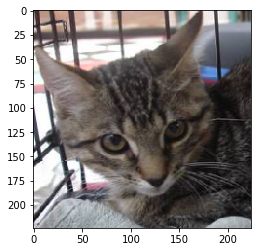

In [36]:
plt.imshow(cats[0]);

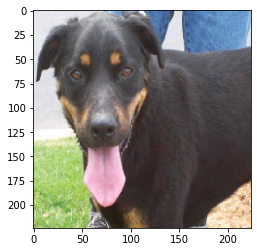

In [37]:
plt.imshow(dogs[9]);

To make it easy to view several images and feature maps at once, we'll first define a couple of utility functions.  By default, ``show_images`` displays the first ten images of the specified dataset.  The optional ``which`` keyword can be used to specify a different range of image indices.  The ``rows`` and ``cols`` keywords specify the maximum number of rows and columns to use for displaying the images.

In [38]:
# general-purpose utility function to display dataset images.

def show_images(images, which=None, rows=2, cols=5):
    # which can be an index number like 0 or a sequence like [0, 2, 4] or range(10)
    if which is None:
        # defaults to all images
        which = range(len(images))
    elif type(which) is int:
        which = [which]
    elif type(which) not in (tuple, list, range):
        print("Please specify a range of image indices")
        return
    plt.figure(figsize=(3*cols,3*rows))  # (width, height) in inches
    k = 0
    for i in which:
        if 0 <= i < len(images):
            k += 1
            plt.subplot(rows, cols, k)
            plt.title('{}'.format(i))
            plt.axis('off')
            plt.imshow(images[i])
            if k == rows*cols:
                break
    if k == 0:
        print("No such image")

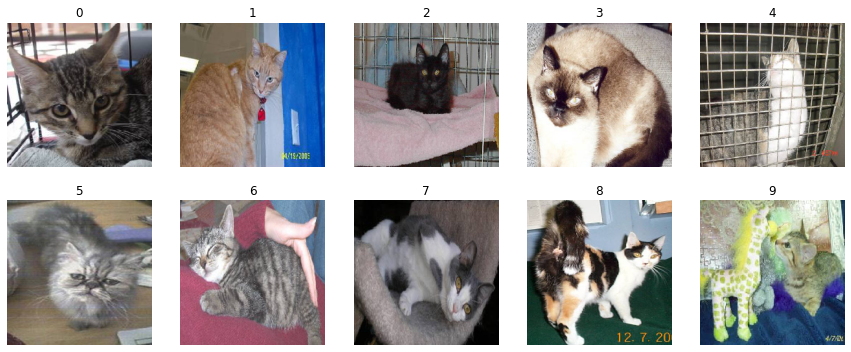

In [39]:
show_images(cats)

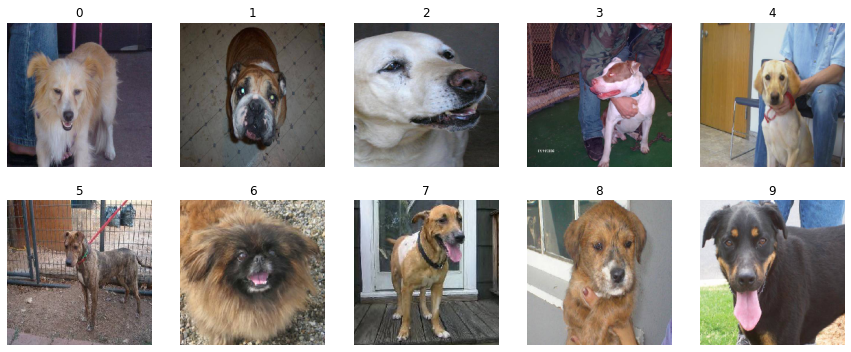

In [40]:
show_images(dogs)

In [41]:
# general-purpose utility function to display the feature maps
# for different channels of a VGG16 convolutional network layer.
#
# example: show_channels(vgg16, image, 'block1_conv1', channels=range(0,20))

from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import Model

def show_channels(net, image, layer_name, channels=range(20), cmap='gray', cols=5):
    # channels can be a number like 0 or a sequence like [0, 2, 4] or range(10)
    layer_names = [layer.name for layer in net.layers]
    if layer_name not in layer_names:
        print('No such layer: {}'.format(layer_name))
        return
    # generate activation maps for layer_name
    input_tensor = net.layers[0].input
    output_tensor = net.get_layer(layer_name).output
    activation_model = Model(inputs=input_tensor, outputs=output_tensor)
    batch = np.array([preprocess_input(image)])
    #output = activation_model.predict(batch)[0]  # using predict causes a weird warning message
    output = activation_model(batch)[0].numpy()
    h, w, d = output.shape
    # display activation maps
    if type(channels) is int:
        channels  = [channels]
    rows = len(channels) // cols
    if len(channels) > rows*cols:
        rows += 1
    plt.figure(figsize=(3*cols,3*rows))  # (width, height) in inches
    k = 0
    for channel in channels:
        if 0 <= channel < d:
            k += 1
            plt.subplot(rows, cols, k)
            plt.imshow(output[:,:,channel], cmap=cmap)
            plt.title('channel {}'.format(channel))
            plt.axis('off')

Let's start with cat image \#11. 

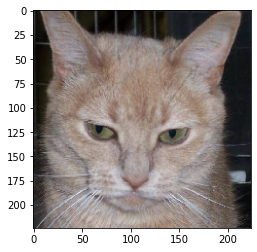

In [42]:
plt.imshow(cats[11]);

We will run this image through the VGG16 network and then look at some of the feature maps generated on the first convolutional layer (``block1_conv1``).  During training, each of the layer's 64 filters learned to respond to different aspects of the input data.  Here are the feature maps generated by the first five filters (channels):

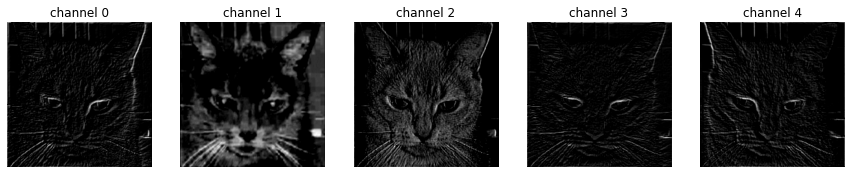

In [43]:
show_channels(vgg16, cats[11], 'block1_conv1', channels=range(5))

Each feature map brings out a different aspect of the original image, although some feature maps may be more similar than others.  For completeness, here are all 64 feature maps generated by the ``block1_conv1`` layer for cat \#11.  Some channels appear to highlight eyes (*e.g.*, channels 12, 27, 36), while others seem to highlight edges between light and dark regions (*e.g.*, channels 4, 6, 7).

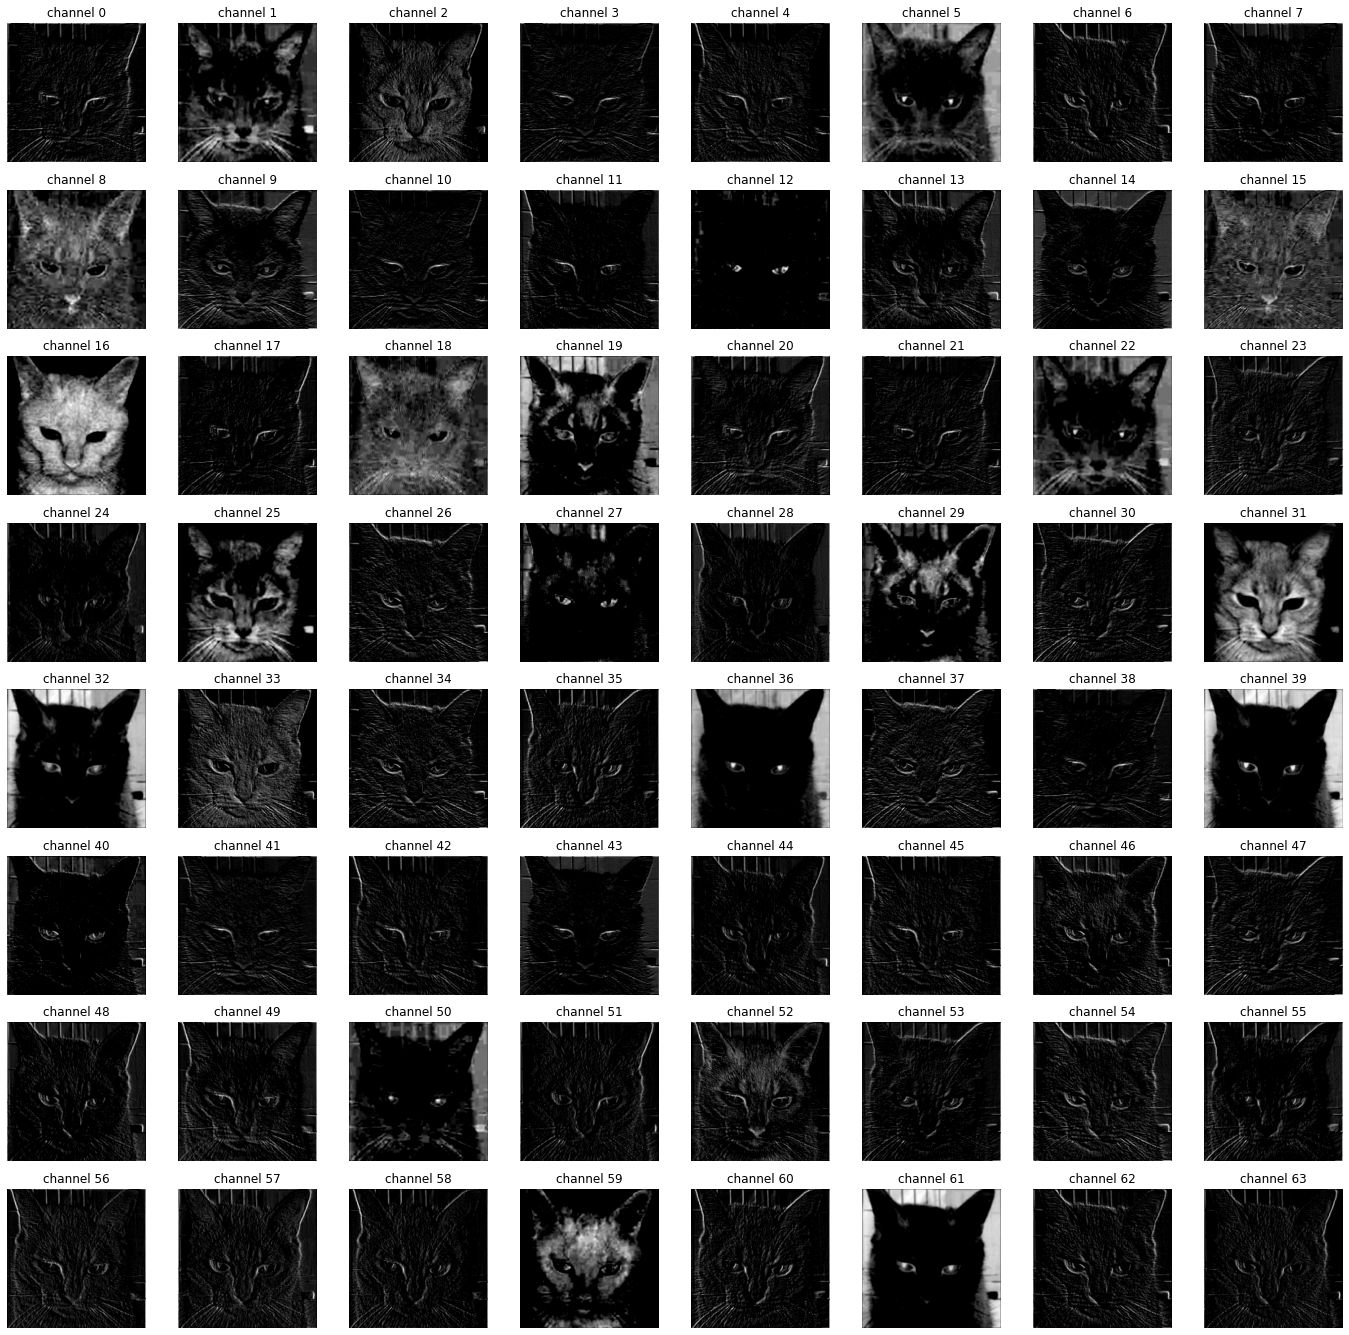

In [44]:
show_channels(vgg16, cats[11], 'block1_conv1', channels=range(64), cols=8)

Next, let's look at the output of the first max-pooling layer, ``block1_pool``.  The max-pooling operation reduces the resolution of each feature map from 224 &times; 224 pixels to 112 &times; 112 pixels, while simultaneously enhancing the most strongly activated areas of each map through the ``max`` operation.

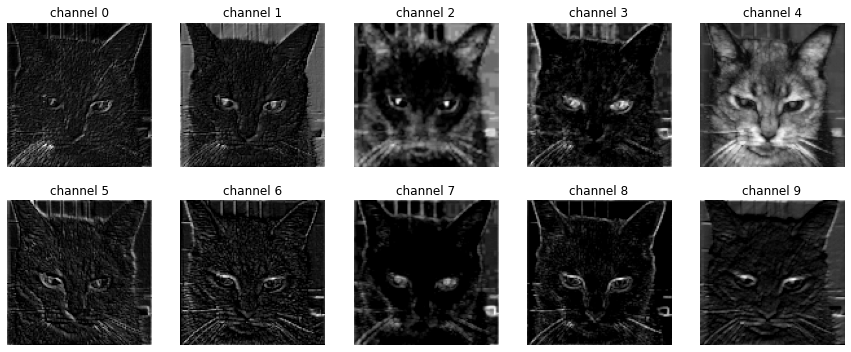

In [45]:
show_channels(vgg16, cats[11], 'block1_pool', channels=range(10))

Each subsequent max-pooling operation further reduces the resolution of the feature maps, while progressively combining information from larger and larger regions of the original input image.  Here are the first ten feature maps generated at the ``block4_pool`` layer:

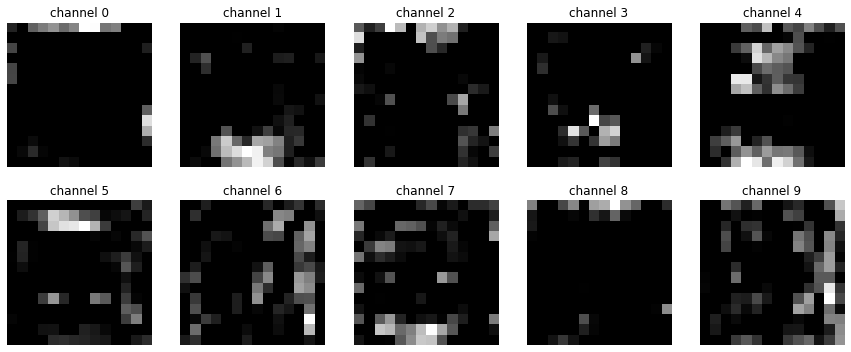

In [46]:
show_channels(vgg16, cats[11], 'block4_pool', channels=range(10))

### Tracing the Transformation of Information

Let's look at a specific image and watch how it gets transformed as it progresses through the network layer by layer. We will start with dog image \#9 and show the first five feature maps generated at each convolutional and max-pooling layer of the network.

In [47]:
input_image = dogs[9]
channels = range(5)

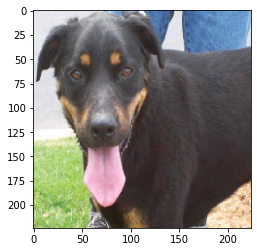

In [48]:
plt.imshow(input_image);

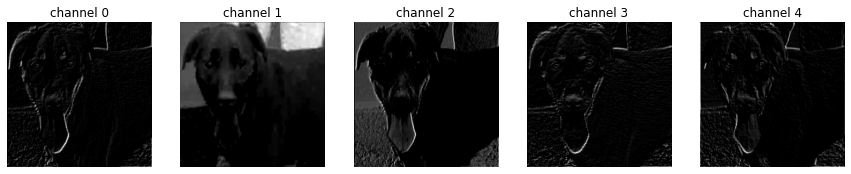

In [49]:
show_channels(vgg16, input_image, 'block1_conv1', channels)

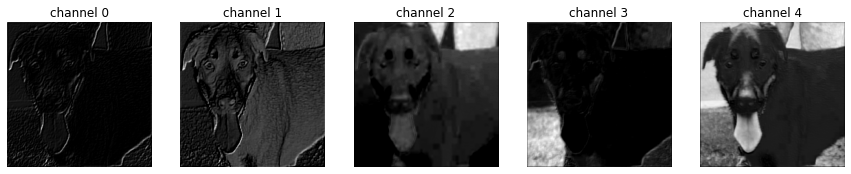

In [50]:
show_channels(vgg16, input_image, 'block1_conv2', channels)

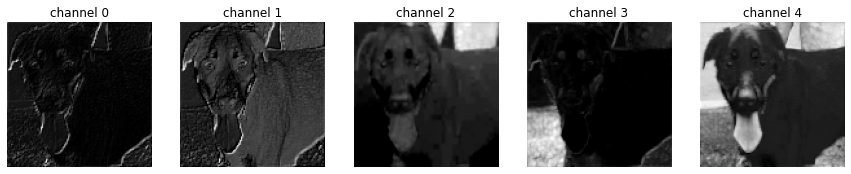

In [51]:
show_channels(vgg16, input_image, 'block1_pool', channels)

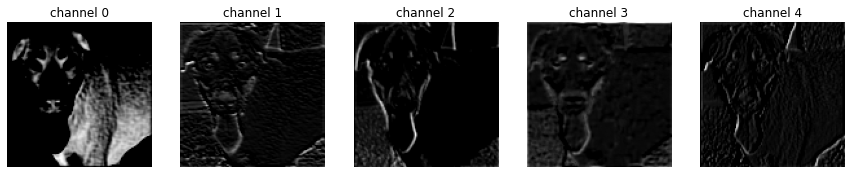

In [52]:
show_channels(vgg16, input_image, 'block2_conv1', channels)

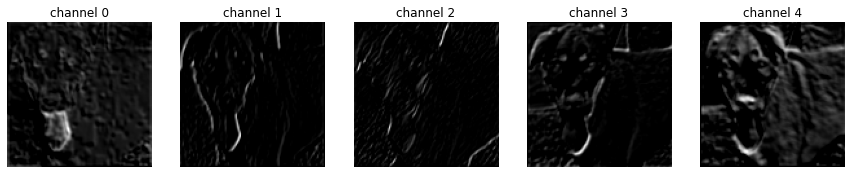

In [53]:
show_channels(vgg16, input_image, 'block2_conv2', channels)

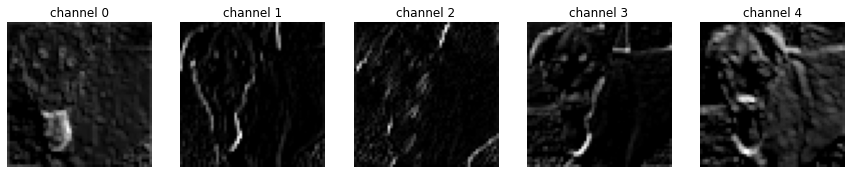

In [54]:
show_channels(vgg16, input_image, 'block2_pool', channels)

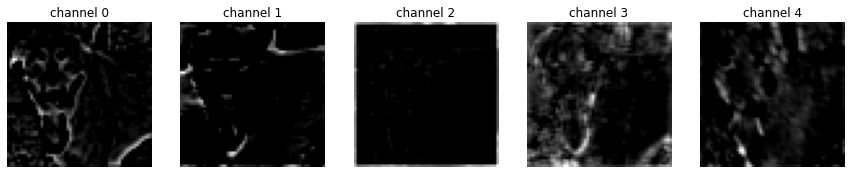

In [55]:
show_channels(vgg16, input_image, 'block3_conv1', channels)

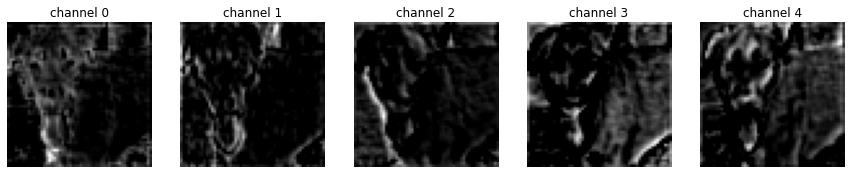

In [56]:
show_channels(vgg16, input_image, 'block3_conv2', channels)

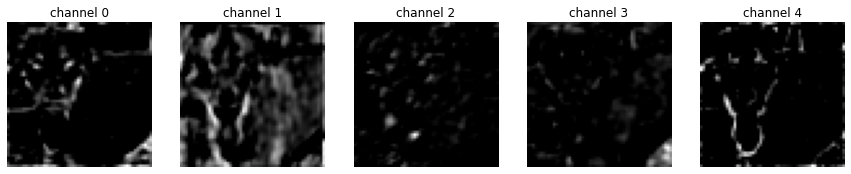

In [57]:
show_channels(vgg16, input_image, 'block3_conv3', channels)

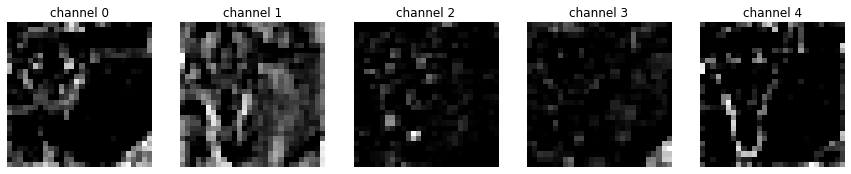

In [58]:
show_channels(vgg16, input_image, 'block3_pool', channels)

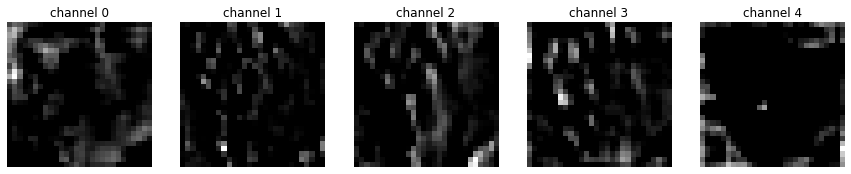

In [59]:
show_channels(vgg16, input_image, 'block4_conv1', channels)

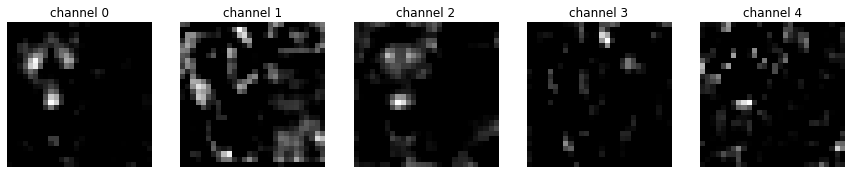

In [60]:
show_channels(vgg16, input_image, 'block4_conv2', channels)

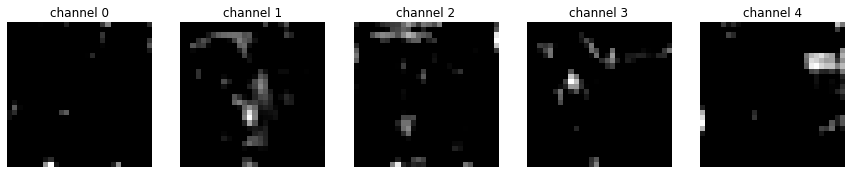

In [61]:
show_channels(vgg16, input_image, 'block4_conv3', channels)

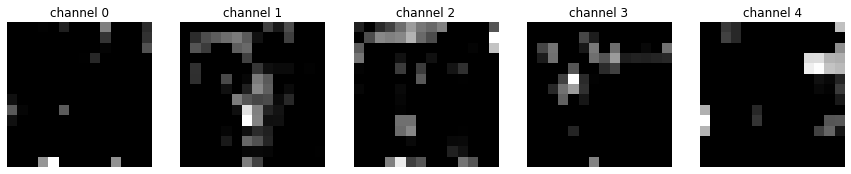

In [62]:
show_channels(vgg16, input_image, 'block4_pool', channels)

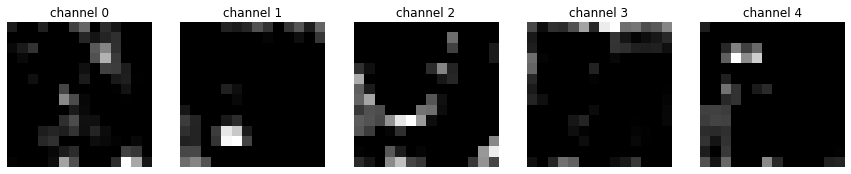

In [63]:
show_channels(vgg16, input_image, 'block5_conv1', channels)

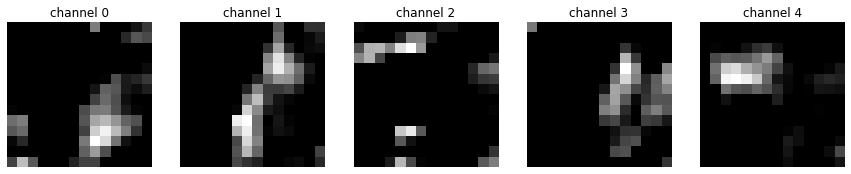

In [64]:
show_channels(vgg16, input_image, 'block5_conv2', channels)

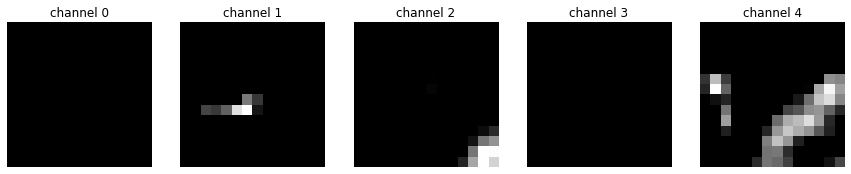

In [65]:
show_channels(vgg16, input_image, 'block5_conv3', channels)

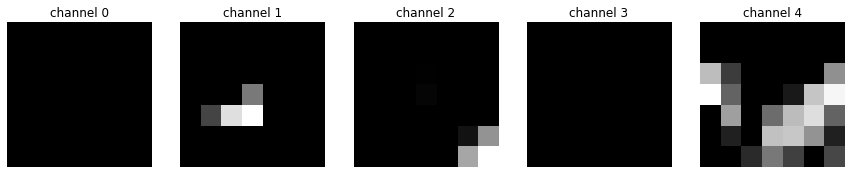

In [66]:
show_channels(vgg16, input_image, 'block5_pool', channels)

In [67]:
layer_names = [layer.name for layer in vgg16.layers if 'block' in layer.name]

for name in layer_names:
    print(name)
    
#for name in layer_names:
#    show_channels(vgg16, input_image, name, channels)

block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
